# Importing Packages and API Setup

In [ ]:
# Only needs to be run upon first-time use
import sys
!{sys.executable} -m pip install alpha_vantage

In [8]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import requests
# https://github.com/RomelTorres/alpha_vantage
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators 
from alpha_vantage.sectorperformance import SectorPerformances

In [9]:
API_URL = 'https://www.alphavantage.co/query?'
API_KEY = 'TMANNBF5NO707ZEI'

In [129]:
# Output formats: json dictionaries (default), DataFrame, csv.
# csv does not support ForeignExchange, SectorPerformances, TechIndicators.
# indexing_type can also be integer (default: date)
ts = TimeSeries(key=API_KEY, output_format='pandas', indexing_type='date')
ti = TechIndicators(key=API_KEY, output_format='pandas')
sp = SectorPerformances(key=API_KEY, output_format='pandas')

# Data Collection

In [131]:
# List to keep all stocks of interest
port = []

def add_to_port(stock_data):
    port.append(stock_data)

In [63]:
# symbols = list of stock tickers as strings
# intraday_interval: '1min', '5min', '15min', '30min', '60min' (default '15min')
def get_data(symbol, start_date= None, end_date= None, type='daily_adjusted', interval= None):
    
    if type=='intraday':
        stock_data, stock_meta_data = ts.get_intraday(symbol, interval=interval, outputsize='full')
    elif type=='daily':
        stock_data, stock_meta_data = ts.get_daily(symbol, outputsize='full')
    elif type=='daily_adjusted':
        stock_data, stock_meta_data = ts.get_daily_adjusted(symbol, outputsize='full')
    elif type=='weekly':
        stock_data, stock_meta_data = ts.get_weekly(symbol)
    elif type=='weekly_adjusted':
        stock_data, stock_meta_data = ts.get_weekly_adjusted(symbol)
    elif type=='monthly':
        stock_data, stock_meta_data = ts.get_monthly(symbol)
    elif type=='monthly_adjusted':
        stock_data, stock_meta_data = ts.get_monthly_adjusted(symbol)
    
    stock_data.rename(columns=lambda col: col[3:], inplace=True)
    
    if start_date and end_date != None:
        stock_data = stock_data.loc[start_date:end_date]
    elif start_date != None:
        stock_data = stock_data.loc[start_date:]
    elif end_date != None:
        stock_data = stock_data.loc[:end_date]
    return pd.DataFrame(stock_data)

# Statistical Measurements

In [184]:
# Stock of interest
SOI = 'AAPL'

In [185]:
def calculate_returns(stock_data):
    
    daily_close = stock_data['close']
    daily_pct_change = daily_close.pct_change()
    daily_pct_change.fillna(0, inplace=True)
    
    daily_log_returns = np.log(daily_close.pct_change()+1)
    daily_log_returns.fillna(0, inplace=True)
    
    # Cumulative daily rate of return is useful to determine the value of an investment at regular intervals.
    cum_daily_return = (1 + daily_pct_change).cumprod()
   # cum_monthly_return = cum_daily_return.resample('M').mean()
    
    return pd.DataFrame({'pct change': daily_pct_change,
                        'log returns':daily_log_returns,
                        'cumulative daily':cum_daily_return})

In [186]:
# Finds the covariance matrix of the stocks within the portfolio.
# Uses closing price
def port_var(port):
    
    for s in port:
        close = np.array(s['close'])
        np.corrcoef()
    var = np.cov()

In [187]:
daily_pct_change = calculate_returns(get_data(SOI, start_date='2018-01-01', end_date='2019-01-01'))[['pct change']]

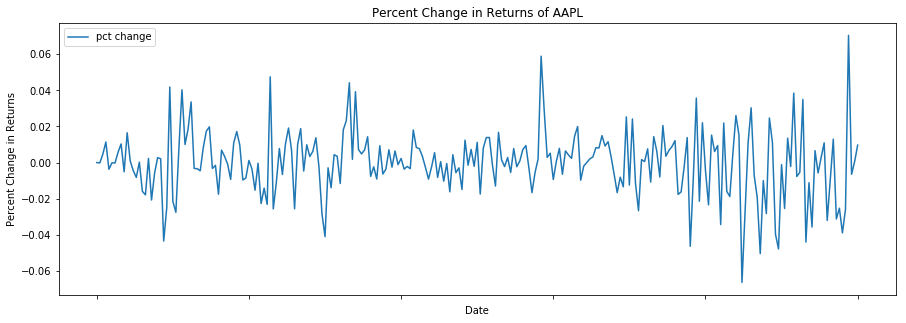

In [188]:
# TODO Fix date axis - show dates
daily_pct_change.plot(figsize=(15,5))
plt.title(f'Percent Change in Returns of {SOI}')
plt.xlabel('Date')
plt.ylabel('Percent Change in Returns')
plt.show()

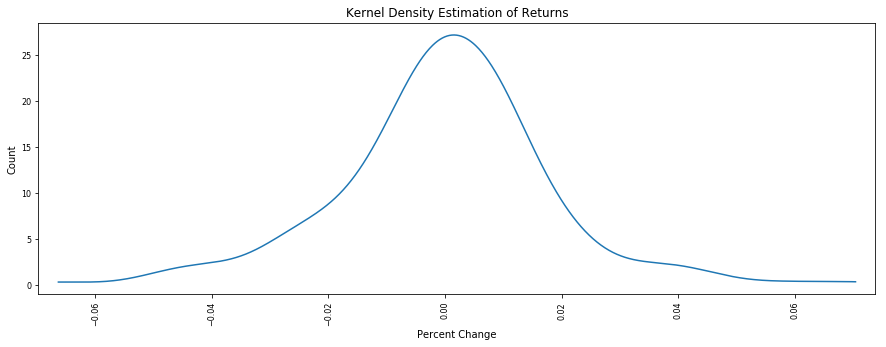

In [181]:
pd.plotting.scatter_matrix(aapl_ret, diagonal='kde', figsize=(15,5))
plt.title('Kernel Density Estimation of Returns')
plt.xlabel('Percent Change')
plt.ylabel('Count')
plt.show()

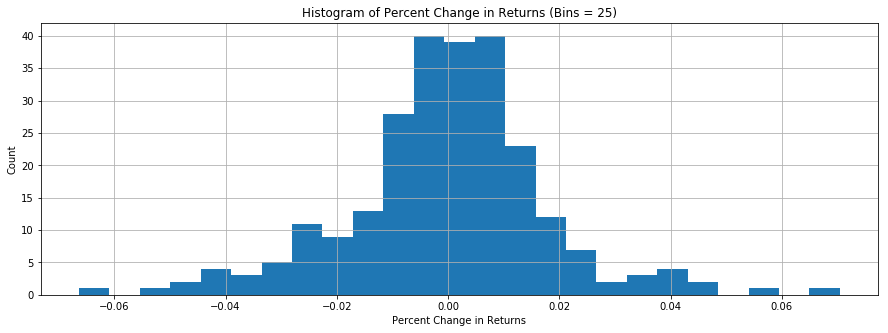

,pct change
count,251.000000
mean,-0.000188
std,0.018073
min,-0.066331
25%,-0.008958
50%,0.000512
75%,0.009263
max,0.070422


In [192]:
bins = 25
daily_pct_change.hist(bins=bins, figsize=(15,5))
plt.title(f'Histogram of Percent Change in Returns (Bins = {bins})')
plt.xlabel('Percent Change in Returns')
plt.ylabel('Count')
plt.show()
daily_pct_change.describe()

In [190]:
min_periods = 25
vol = daily_pct_change['pct change'].rolling(min_periods).std()*np.sqrt(min_periods)

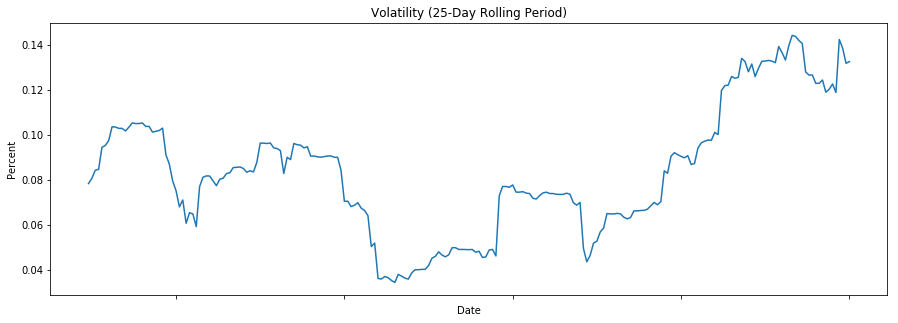

count    227.000000
mean       0.083500
std        0.028205
min        0.034270
25%        0.065179
50%        0.082768
75%        0.098894
max        0.144299
Name: pct change, dtype: float64


In [191]:
vol.plot(figsize=(15,5))
plt.title(f'Volatility ({min_periods}-Day Rolling Period)')
plt.xlabel('Date')
plt.ylabel('Percent')
plt.show()
print(vol.describe())